# Task B

In [29]:
!pip install spaghetti osmnx pyproj esda

In [35]:
import osmnx as ox
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from helpers.location_converter import ENtoLL84
from scipy.stats import gaussian_kde
import numpy as np
import esda
from geopandas import GeoDataFrame
import spaghetti

In [31]:

df2014 = pd.read_csv('../data/clean_2014.csv')
df2015 = pd.read_csv('../data/clean_2015.csv')
df2016 = pd.read_csv('../data/clean_2016.csv')
df2017 = pd.read_csv('../data/clean_2017.csv')
df2018 = pd.read_csv('../data/clean_2018.csv')
df2019 = pd.read_csv('../data/clean_2019.csv')

all_datasets = [df2014, df2015, df2016, df2017, df2018, df2019]

## Task B.1

Plot the distribution of road accidents on your road network and visualise this. Aggregate across multiple years of accident data.

In [32]:
concat_data = pd.concat(all_datasets)

concat_data[['longitude', 'latitude']] = concat_data.apply(lambda row: pd.Series(ENtoLL84(row['Grid Ref: Easting'], row['Grid Ref: Northing'])), axis=1)

concat_data.to_csv('concat_data.csv')

/home/john_kelly_tamargo/NDA/NDACW2/taskB/helpers/location_converter.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return transform(v36, v84, vlon36, vlat36) # (longitude, latitude)


In [33]:
PLACE_OF_INTEREST = "Leeds, United Kingdom"

area = ox.geocode_to_gdf(PLACE_OF_INTEREST)

### Spatial Plots

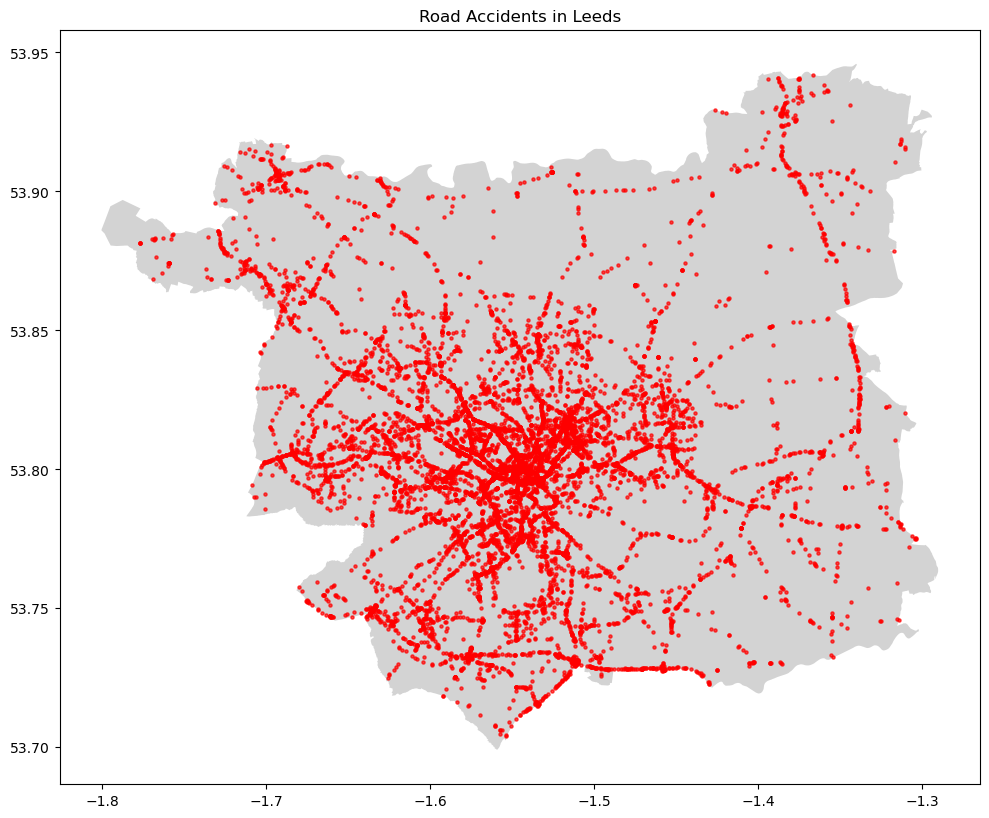

In [7]:
# Without Roads
gdf = gpd.GeoDataFrame(concat_data, geometry = gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
gdf.crs = "EPSG:4326"

fig, ax = plt.subplots(figsize=(10, 10))
area.plot(ax=ax, facecolor='lightgray')

gdf.plot(ax=ax, markersize=5, color='red', alpha=0.7)

ax.set_title("Road Accidents in Leeds")


Text(0.5, 1.0, 'Road Accidents in Leeds')

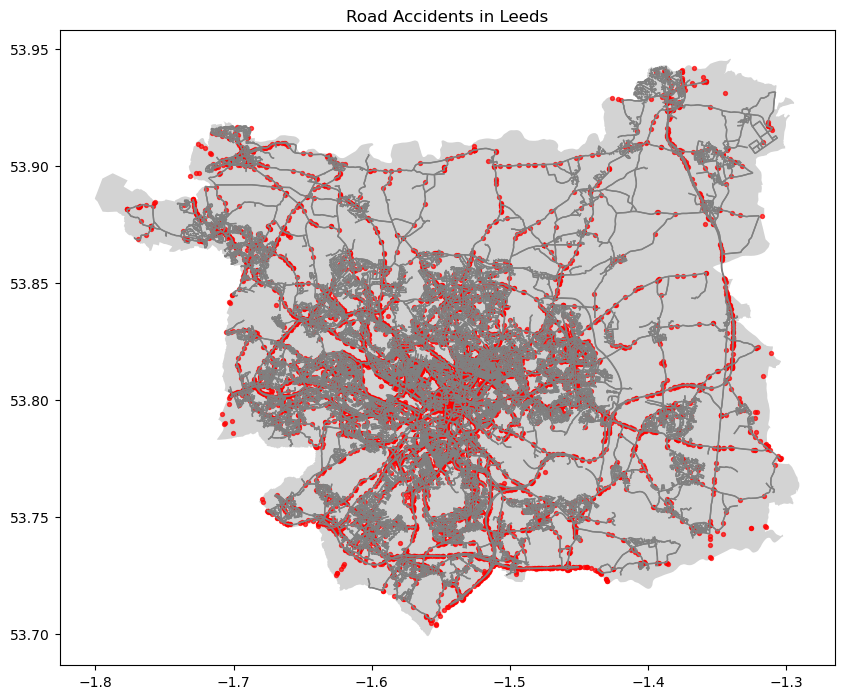

In [16]:
graph_with_roads = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')
fig, ax = plt.subplots(figsize=(10, 10))

gdf = gpd.GeoDataFrame(concat_data, geometry = gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
gdf.crs = "EPSG:4326"

area.plot(ax=ax, facecolor='lightgray')

# Plot the roads
edges = ox.graph_to_gdfs(graph_with_roads, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=1, edgecolor='gray')

gdf.plot(ax=ax, markersize=8, color='red', alpha=0.7)

ax.set_title("Road Accidents in Leeds")

### Density Plots

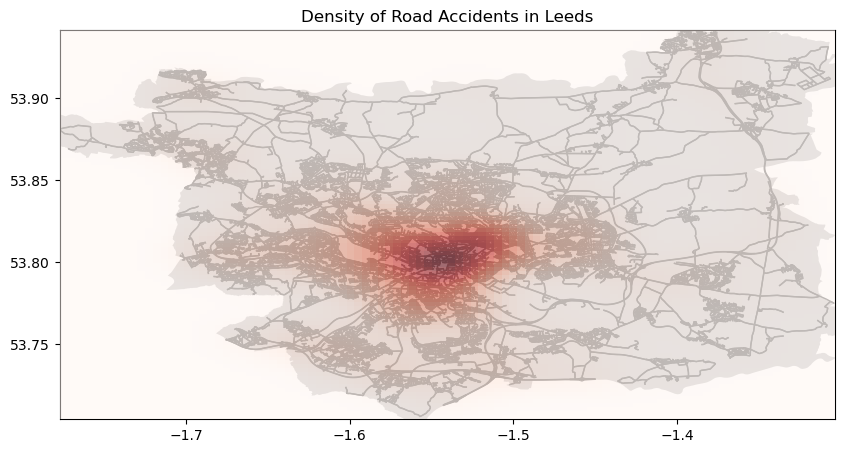

In [14]:
gdf = gpd.GeoDataFrame(concat_data, geometry=gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(area.crs)

x = gdf.geometry.x
y = gdf.geometry.y
kde = gaussian_kde([x, y])
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)

fig, ax = plt.subplots(figsize=(10, 10))

area.plot(ax=ax, color='lightgray', zorder=1)
edges = ox.graph_to_gdfs(graph_with_roads, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=1, edgecolor='gray', zorder=2)

ax.imshow(np.rot90(f), cmap='Reds', extent=[x.min(), x.max(), y.min(), y.max()], zorder=3, alpha=0.5)


ax.set_title("Density of Road Accidents in Leeds")


## Task B.2
- Investigate whether a high number of accidents on one road correlates with a high number on connecting roads. 
- Calculate the k-function and the Moran's I values for the above spatial graph.

K-Values

In [ ]:
graph = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')
roads_geodataframe = ox.graph_to_gdfs(graph, nodes=False, edges=True)

# road_gdf = GeoDataFrame(pd.DataFrame(PLACE_OF_INTEREST))

leeds_accidents = (concat_data[], )

leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["crimes"],
    nsteps=50, permutations=50
)